# Optimal structural resolution parameter range

Explore broad range of structural resolution parameter gamma to find out optimal range for further modularity analysis. Two heuristics are used: one based on module size and number of modules and another based on similarity between partitions.

### Resolution-related metrics

Calculate various metrics related to changing value of community resolution parameter γ.

#### Module size metrics

First set of measures is related to module sizes. For smaller values of γ there are few large modules, whereas larger values of γ produce more smaller modules, often single isolated nodes called singletons. Calculated statistics:
- `n_singleton`: mean number of singletons (isolated node modules)
- `n_nonsingleton`: mean number of modules of size greater or equal 2
- `n_modules`: mean total number of modules
- `min_module_size`: mean minimal module size
- `max_module_size` mean maximal module size

### Similarity metrics

Next set of measures is related to similarity between partitions of different type. Partiton distance can be calculated as normalized mutual information between two community vectors (implemented in BCTpy function `partition_distance`). Different types of similarities are depicted below:

<center><img src="../partition_similarity_types.png" width="800"/></center>

- `reference`: distance between a priori Power partition and data driven partitions
- `rew_inc`, `rew_dec`, `pun_inc`, `pun_dec`: distance within single condition
- `within_con`: distance between vevtors within the same condition
- `cross_con` distance between vectors from different conditions
- `rew`, `pun`, `inc`, `dec`: distance within single condition class (e.g. reward condition, both PEs)
- `within_sub`: distance within single subject
- `cross_sub`: distance between vectors from different subjects
- `data` distance between all pairs of data-driven paritions

Measures of `within_con` and `cross_con` (and `within_sub` and `cross_sub`) are calculated on exclusive set of partitions so their weighed average should be equal to `data` measure.


In [1]:
import json
import math
import os
from itertools import combinations, product
from os.path import join
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bct.algorithms.modularity import community_louvain, partition_distance
from dn_utils.path import path
from tqdm.notebook import tqdm

%matplotlib inline

### Settings

In [2]:
atlas = "combined_roi"

In [3]:
# Create paths
path_corrmats = join(path["bsc"], "corrmats")
path_corrmats_gamma_exploration = join(path_corrmats, atlas, 
                                       "unthr/gamma_exploration")
Path(path_corrmats_gamma_exploration).mkdir(exist_ok=True)

# Load correlation matrices and metadata
corrmats_aggregated = np.load(
    join(path_corrmats, atlas, "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    meta = json.loads(f.read())

# Load subject exclusion
df_exclusion = pd.read_csv(
    join(path["nistats"], "exclusion/exclusion.csv"), index_col=0)
ok_index = df_exclusion["ok_all"]    
corrmats_aggregated = corrmats_aggregated[ok_index]

# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, "roi_table_filtered.csv"))
m_atlas = np.array(df_roi["netName"].astype("category").cat.codes)

n_subjects = len(meta["dim1"])
n_subjects_ok = sum(ok_index)
n_conditions = len(meta["dim2"])
n_perr_sign = len(meta["dim3"])
n_rois = len(df_roi)

iters = product(range(n_subjects_ok), range(n_conditions), range(n_perr_sign))
iters = list(iters)

In [4]:
# Modularity parameters
louvain_B = "negative_asym"
louvain_reps = 100

# Explored gamma range
gamma_range = np.arange(0.05, 3.05, 0.05)
n_gamma = len(gamma_range)
gamma_range

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
       2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75,
       2.8 , 2.85, 2.9 , 2.95, 3.  ])

In [5]:
path_q = join(path_corrmats_gamma_exploration, "q_aggregated.npy")
path_m = join(path_corrmats_gamma_exploration, "m_aggregated.npy")

if not os.path.exists(path_q):

    m = np.zeros((n_gamma, n_subjects_ok, n_conditions, n_perr_sign, n_rois))
    q = np.ones((n_gamma, n_subjects_ok, n_conditions, n_perr_sign)) * (-np.inf)

    for gamma_idx, gamma in tqdm(list(enumerate(gamma_range))):

        # Calculate modularity for specific gamma
        for sub_idx, con_idx, perr_sign_idx in iters:
            corrmat = corrmats_aggregated[sub_idx, con_idx, perr_sign_idx]
            corrmat[np.diag_indices_from(corrmat)] = 0
            for _ in range(louvain_reps):
                mt, qt = community_louvain(corrmat, gamma=gamma, B=louvain_B)
                if qt > q[gamma_idx, sub_idx, con_idx, perr_sign_idx]:
                    m[gamma_idx, sub_idx, con_idx, perr_sign_idx] = mt
                    q[gamma_idx, sub_idx, con_idx, perr_sign_idx] = qt

    np.save(path_q, q)
    np.save(path_m, q)

else:

    m = np.load(path_m)
    q = np.load(path_q)

In [6]:
columns_module_size = [
    "n_singleton",
    "n_nonsingleton",
    "mean_module_size",
    "min_module_size",
    "max_module_size"
]

columns_similarity = [
    "reference",
    "rew_inc",
    "rew_dec",
    "pun_inc",
    "pun_dec",
    "cross_con",
    "rew", 
    "pun", 
    "inc", 
    "dec",
    "within_sub",
    "cross_sub"
]

df_ms = pd.DataFrame(index=gamma_range, columns=columns_module_size)
df_sim = pd.DataFrame(index=gamma_range, columns=columns_similarity)

df_ms = df_ms.fillna(0)
df_sim = df_sim.fillna(0)

In [7]:
n_entities = n_subjects_ok * n_conditions * n_perr_sign

for gamma_idx, gamma in tqdm(list(enumerate(gamma_range))):
    for sub_idx, con_idx, perr_sign_idx in iters:

        mt = m[gamma_idx, sub_idx, con_idx, perr_sign_idx]

        # Module size distribution
        counts = np.unique(mt, return_counts=True)[1]
        df_ms.loc[gamma, "n_singleton"] += np.sum(counts == 1)
        df_ms.loc[gamma, "n_nonsingleton"] += np.sum(counts != 1)
        df_ms.loc[gamma, "mean_module_size"] += np.mean(counts)
        df_ms.loc[gamma, "min_module_size"] += np.min(counts)        
        df_ms.loc[gamma, "max_module_size"] += np.max(counts)
        
df_ms = df_ms / n_entities

df_ms["n_modules"] = df_ms["n_singleton"] + df_ms["n_nonsingleton"]

  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
n_subject_pairs = math.comb(n_subjects_ok, 2)
n_condition_pairs = math.comb(n_conditions * n_perr_sign, 2)

path_df_sim = join(path_corrmats_gamma_exploration, "measures_similarity.csv")

if os.path.exists(path_df_sim):
    df_sim = pd.read_csv(path_df_sim, index_col=0)

else:
    for gamma_idx, gamma in tqdm(list(enumerate(gamma_range))):

        for sub_idx, con_idx, perr_sign_idx in iters:
            # Reference similarity (with a priori atlas)
            mt = m[gamma_idx, sub_idx, con_idx, perr_sign_idx]
            df_sim.loc[gamma, "reference"] += partition_distance(mt, m_atlas)[1]

        for sub_1, sub_2 in combinations(range(n_subjects_ok), 2):
            df_sim.loc[gamma, "rew_inc"] += np.nansum(partition_distance(
                m[gamma_idx, sub_1, 0, 0], m[gamma_idx, sub_2, 0, 0])[1])
            df_sim.loc[gamma, "rew_dec"] += np.nansum(partition_distance(
                m[gamma_idx, sub_1, 0, 1], m[gamma_idx, sub_2, 0, 1])[1])
            df_sim.loc[gamma, "pun_inc"] += np.nansum(partition_distance(
                m[gamma_idx, sub_1, 1, 0], m[gamma_idx, sub_2, 1, 0])[1])  
            df_sim.loc[gamma, "pun_dec"] += np.nansum(partition_distance(
                m[gamma_idx, sub_1, 1, 1], m[gamma_idx, sub_2, 1, 1])[1])        

        for sub_1, sub_2 in product(range(n_subjects_ok), repeat=2):
            for (ci1, pi1), (ci2, pi2) in combinations(product(range(2), 
                                                               repeat=2), 2):
                df_sim.loc[gamma, "cross_con"] += np.nansum(partition_distance(
                    m[gamma_idx, sub_1, ci1, pi1], 
                    m[gamma_idx, sub_2, ci2, pi2])[1])

        m_rew = np.reshape(m[gamma_idx, :, 0], (n_subjects_ok * 2, n_rois))
        m_pun = np.reshape(m[gamma_idx, :, 1], (n_subjects_ok * 2, n_rois))     
        m_inc = np.reshape(m[gamma_idx, :, :, 0], (n_subjects_ok * 2, n_rois))
        m_dec = np.reshape(m[gamma_idx, :, :, 1], (n_subjects_ok * 2, n_rois))

        for i1, i2 in combinations(range(n_subjects_ok * 2), 2):
            df_sim.loc[gamma, "rew"] += np.nansum(partition_distance(
                m_rew[i1], m_rew[i2])[1])
            df_sim.loc[gamma, "pun"] += np.nansum(partition_distance(
                m_pun[i1], m_pun[i2])[1])
            df_sim.loc[gamma, "inc"] += np.nansum(partition_distance(
                m_inc[i1], m_inc[i2])[1])
            df_sim.loc[gamma, "dec"] += np.nansum(partition_distance(
                m_dec[i1], m_dec[i2])[1])

        for sub_idx in range(n_subjects_ok):
            for (ci1, pi1), (ci2, pi2) in combinations(product(range(2), 
                                                               repeat=2), 2):
                df_sim.loc[gamma, "within_sub"] += np.nansum(partition_distance(
                    m[gamma_idx, sub_idx, ci1, pi1], 
                    m[gamma_idx, sub_idx, ci2, pi2])[1])

        for sub_1, sub_2 in combinations(range(n_subjects_ok), 2):
            for (ci1, pi1), (ci2, pi2) in product(product(range(2), 
                                                          repeat=2), repeat=2):
                df_sim.loc[gamma, "cross_sub"] += np.nansum(partition_distance(
                    m[gamma_idx, sub_1, ci1, pi1], 
                    m[gamma_idx, sub_2, ci2, pi2])[1])

    # Mean calculation
    df_sim["reference"] = df_sim["reference"] / n_entities 

    for col in ["rew_inc", "rew_dec", "pun_inc", "pun_dec"]:
        df_sim[col] = df_sim[col] / n_subject_pairs

    for col in ["rew", "pun", "inc", "dec"]:
        df_sim[col] = df_sim[col] / math.comb(2 * n_subjects_ok, 2)

    df_sim["cross_con"] = df_sim["cross_con"] / (n_subjects_ok ** 2 * n_condition_pairs)
    df_sim["within_con"] = df_sim[["rew_inc", "rew_dec", "pun_inc", "pun_dec"]].mean(axis=1)

    df_sim["within_sub"] = df_sim["within_sub"] / (n_subjects_ok * n_condition_pairs)
    df_sim["cross_sub"] = df_sim["cross_sub"] / (n_subject_pairs * 4 ** 2)

    df_sim["data_con"] = (df_sim["within_con"] * (4 * n_subject_pairs)
                        + df_sim["cross_con"] * (n_subjects_ok ** 2 * n_condition_pairs)) / math.comb(n_subjects_ok * 4, 2) 
    df_sim["data_sub"] = (df_sim["within_sub"] * (n_subjects_ok * n_condition_pairs) 
                        + df_sim["cross_sub"] * (n_subject_pairs * 4 ** 2)) / math.comb(n_subjects_ok * 4, 2)

    # Sanity check
    if any(~np.isclose(df_sim["data_con"], df_sim["data_sub"])):
        raise Exception("Mean similarity for entire dataset mismatch")

    df_sim["data"] = df_sim["data_con"]
    df_sim = df_sim.drop(["data_con", "data_sub"], axis=1)
    df_sim.to_csv(path_df_sim)

In [9]:
# All nets
n_all = math.comb(n_subjects_ok * 4, 2)

# Within & cross condition
n_within_con = n_subject_pairs * 4
n_cross_con = n_condition_pairs * n_subjects_ok ** 2 

# Within & cross subject 
n_within_sub = n_condition_pairs * n_subjects_ok
n_cross_sub = n_subject_pairs * 4 ** 2

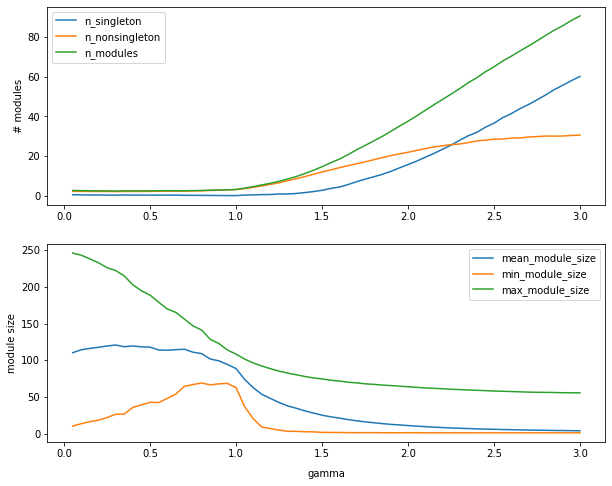

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8))

df_ms.filter(regex="^n_*").plot(ax=ax1)
df_ms.filter(regex="module_size").plot(ax=ax2)

ax1.set_ylabel("# modules")
ax2.set_ylabel("module size")
ax2.set_xlabel("gamma", labelpad=10);

Text(0.5, 0, 'gamma')

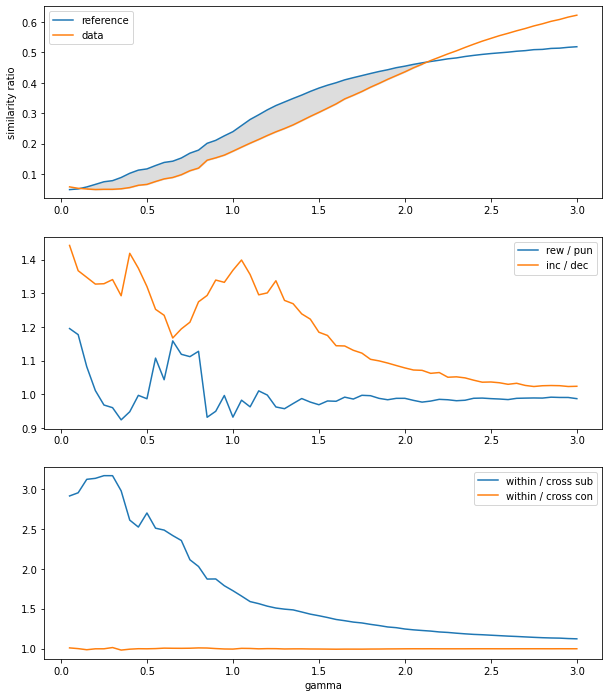

In [11]:
optimal_range = df_sim["reference"] > df_sim["data"] 
optimal_range_values = optimal_range[optimal_range].index

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 12))

df_sim[["reference", "data"]].plot(ax=ax1)
ax1.fill_between(
    optimal_range_values, 
    df_sim["data"][optimal_range], 
    df_sim["reference"][optimal_range],
    color="#ddd"
)

ax2.plot(df_sim["rew"] / df_sim["pun"], label="rew / pun")
ax2.plot(df_sim["inc"] / df_sim["dec"], label="inc / dec")
ax2.legend()

ax3.plot(df_sim["within_sub"] / df_sim["cross_sub"], label="within / cross sub")
ax3.plot(df_sim["within_con"] / df_sim["cross_con"], label="within / cross con")
ax3.legend()

ax1.set_ylabel("similarity")
ax1.set_ylabel("similarity ratio")
ax1.set_ylabel("similarity ratio")
ax3.set_xlabel("gamma")